In [64]:
import pandas as pd
import numpy as np
import json
import datetime as dt

### Station
??? - region 0 //
Europe - region 1 //
Oceania - region 2 //
N America - region 3 //
Asia - region 4 //
C/S America - region 5 //
Africa - region 6 //
Japan - region 7

In [18]:
lat=49.3996597
lon=15.5970656
region=1

start=dt.datetime(2020,5,11,16,0)
end=dt.datetime(2020,5,11,18,0)

import os, time
os.environ['TZ'] = 'UTC'
time.tzset()

#print(dt.datetime.now())

start=int(start.timestamp())*1000000000
end=int(end.timestamp())*1000000000

start=pd.to_datetime(start, unit='ns')
end=pd.to_datetime(end, unit='ns')
print(start,end)

2020-05-11 16:00:00 2020-05-11 18:00:00


In [19]:
### url for json data preparation
'''print(pd.to_datetime(start, unit='ns'))
print(pd.to_datetime(next, unit='ns'))
print(pd.to_datetime(end, unit='ns'))
print(np.ceil((end-start).total_seconds()/600))'''
url=[]
for i in range(0,int(np.ceil((end-start).total_seconds()/600)+1)):
    next=start+ pd.Timedelta(minutes=i*10)
    url.append('http://data.blitzortung.org/Data/Restricted/Strikes_%01d/%02d/%02d/%02d/%02d/%02d.json' % (region, next.year, next.month, next.day, next.hour, np.floor((next.minute)//10)*10))

In [20]:
import requests
blitz=pd.DataFrame()
for i in range(len(url)):
    try:
        html = requests.get(url[i]).content
        blitz_part = pd.read_json(html,lines=True)
        blitz_part.drop(columns=['status','sig'], inplace=True)#,'region', 
        blitz=blitz.append(blitz_part)
    except:
        print("No data", url[i])
blitz.set_index(['time'], inplace=True)
blitz

lat        lon  alt  pol    mds  mcg  region
time                                                                   
1589212801136250382  52.270369  20.510259    0    0   6668  131       1
1589212801136245117  52.280896  20.562023    0    0   9065  186       1
1589212801677906650  49.576910  15.677801    0    0   7361  101       1
1589212801946362393  49.447060  15.733651    0    0   8199   59       1
1589212802457473281  49.407937  15.587958    0    0   6850  143       1
...                        ...        ...  ...  ...    ...  ...     ...
1589220595735588785  46.046564  12.865681    0    0  12579   96       1
1589220595911255769  45.804165  12.358225    0    0  10945  118       1
1589220595911266518  45.900227  12.371352    0    0   5462   99       1
1589220595911265718  45.871965  12.376282    0    0   5891  191       1
1589220597219114207  52.894788  21.353228    0    0   6930   94       1

[16167 rows x 7 columns]

In [6]:
### reduction of too distant events
blitz=blitz[(blitz['lat']>(lat-1) )&(blitz['lat']<(lat+1) )]
blitz=blitz[(blitz['lon']>(lon-1) )&(blitz['lon']<(lon+1) )]
#print(blitz)
### calculation of distance of events from station
from math import radians, cos, sin, asin, sqrt, atan2, degrees

def haversine2(lon1,lat1,lon2,lat2):
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2.)**2. + cos(lat1) * cos(lat2) * sin(dlon/2.)**2.
    c = 2. * asin(sqrt(a)) 
    km = 6367. * c
    return km
 # with function
'''blitz['distance']=100
for i in range(len(blitz['lat'])):
    blitz['distance'][i]=haversine2(blitz.lon.iloc[i],blitz.lat.iloc[i],lon,lat)'''
    
#with pandas
blitz['lonRad']=np.radians(blitz.lon)
blitz['latRad']=np.radians(blitz.lat)
lonRad=np.radians(lon)
latRad=np.radians(lat)
blitz['DlonRad']=lonRad-blitz.lonRad
blitz['DlatRad']=latRad-blitz.latRad
blitz['a']=np.sin(blitz.DlatRad/2.)**2. + np.cos(blitz.latRad) * np.cos(latRad) * np.sin(blitz.DlonRad/2.)**2.
blitz['km'] = 2. * np.arcsin(np.sqrt(blitz.a))*6378.
blitz.drop(columns=['lonRad','latRad','DlonRad','DlatRad','a'], inplace=True)
try:
    blitz.drop(columns=['alt','pol','region'], inplace=True)
except:
    print('No columns to drop (alt, pol, region)')
blitz['time']=blitz.index
blitz

No columns to drop (alt, pol, region)


lat        lon    mds  mcg          km  \
time                                                                
1589212801677906650  49.576910  15.677801   7361  101   20.576580   
1589212801946362393  49.447060  15.733651   8199   59   11.209380   
1589212802457473281  49.407937  15.587958   6850  143    1.133236   
1589212802526827896  49.405487  15.593112   6768   71    0.709087   
1589212802526824901  49.421077  15.604264   7075   80    2.440451   
...                        ...        ...    ...  ...         ...   
1589219171060928622  48.405994  16.583480  13495   97  132.076044   
1589219171152579572  48.425541  16.593938   7584   72  130.676828   
1589219553664241706  48.460824  16.569251  10354  152  126.397825   
1589219693677685353  48.413476  16.520912   7616  228  128.918554   
1589219816792887288  48.423840  16.546506   5462   97  128.932804   

                                    time  
time                                      
1589212801677906650  1589212801677906650  
1589212801946362393  1589212801946362393  
1589212802457473281  1589212802457473281  
1589212802526827896  1589212802526827896  
1589212802526824901  1589212802526824901  
...                                  ...  
1589219171060928622  1589219171060928622  
1589219171152579572  1589219171152579572  
1589219553664241706  1589219553664241706  
1589219693677685353  1589219693677685353  
1589219816792887288  1589219816792887288  

[4814 rows x 6 columns]

In [16]:
blitz.loc[blitz['km']<10]
blitz['time']
blitz['time'] = pd.to_datetime(blitz.index, unit='ns')
blitz


lat        lon    mds  mcg          km  \
time                                                                
1589212801677906650  49.576910  15.677801   7361  101   20.576580   
1589212801946362393  49.447060  15.733651   8199   59   11.209380   
1589212802457473281  49.407937  15.587958   6850  143    1.133236   
1589212802526827896  49.405487  15.593112   6768   71    0.709087   
1589212802526824901  49.421077  15.604264   7075   80    2.440451   
...                        ...        ...    ...  ...         ...   
1589219171060928622  48.405994  16.583480  13495   97  132.076044   
1589219171152579572  48.425541  16.593938   7584   72  130.676828   
1589219553664241706  48.460824  16.569251  10354  152  126.397825   
1589219693677685353  48.413476  16.520912   7616  228  128.918554   
1589219816792887288  48.423840  16.546506   5462   97  128.932804   

                                             time  
time                                               
1589212801677906650 2020-05-11 16:00:01.677906650  
1589212801946362393 2020-05-11 16:00:01.946362393  
1589212802457473281 2020-05-11 16:00:02.457473281  
1589212802526827896 2020-05-11 16:00:02.526827896  
1589212802526824901 2020-05-11 16:00:02.526824901  
...                                           ...  
1589219171060928622 2020-05-11 17:46:11.060928622  
1589219171152579572 2020-05-11 17:46:11.152579572  
1589219553664241706 2020-05-11 17:52:33.664241706  
1589219693677685353 2020-05-11 17:54:53.677685353  
1589219816792887288 2020-05-11 17:56:56.792887288  

[4814 rows x 6 columns]

In [22]:
df = blitz

import plotly.express as px
'''fig = px.scatter_geo(df, lon="lon", lat='lat' ,color="time",
                     hover_name="km",
                    projection="natural earth"
                    )'''
fig = px.scatter(df, x="lon", y='lat' ,color="time",
                     hover_name="km",
                    )
fig.show()
fig.write_html("./blitzortung/blesky.html")

In [74]:
#2020-05-11 14:19:36 2020-05-11 17:27:10 49.17523 14.677353333333333

lat=49.17523
lon=14.677353333333333
region=1

start=dt.datetime(2020,5,11,13,0)
end=dt.datetime(2020,5,11,16,0)

import os, time
os.environ['TZ'] = 'UTC'
time.tzset()

#print(dt.datetime.now())

start=int(start.timestamp())*1000000000
end=int(end.timestamp())*1000000000

start=pd.to_datetime(start, unit='ns')
end=pd.to_datetime(end, unit='ns')
print(start,end)

### url for json data preparation
'''print(pd.to_datetime(start, unit='ns'))
print(pd.to_datetime(next, unit='ns'))
print(pd.to_datetime(end, unit='ns'))
print(np.ceil((end-start).total_seconds()/600))'''
url=[]
for i in range(0,int(np.ceil((end-start).total_seconds()/600)+1)):
    next=start+ pd.Timedelta(minutes=i*10)
    url.append('http://data.blitzortung.org/Data/Restricted/Strikes_%01d/%02d/%02d/%02d/%02d/%02d.json' % (region, next.year, next.month, next.day, next.hour, np.floor((next.minute)//10)*10))

import requests
blitz=pd.DataFrame()
for i in range(len(url)):
    try:
        html = requests.get(url[i]).content
        blitz_part = pd.read_json(html,lines=True)
        blitz_part.drop(columns=['status','sig'], inplace=True)#,'region', 
        blitz=blitz.append(blitz_part)
    except:
        print("No data", url[i])
#blitz.set_index(['time'], inplace=True)

2020-05-11 13:00:00 2020-05-11 16:00:00


47.880541   14.118343
http://server.arcgisonline.com/ArcGIS/rest/services/ESRI_StreetMap_World_2D/MapServer/export?bbox=1522556.0084663494,6137551.448802974,1745194.9900528966,6357625.680235187&bboxSR=3395&imageSR=3395&size=1000,988&dpi=96&format=png32&transparent=true&f=image


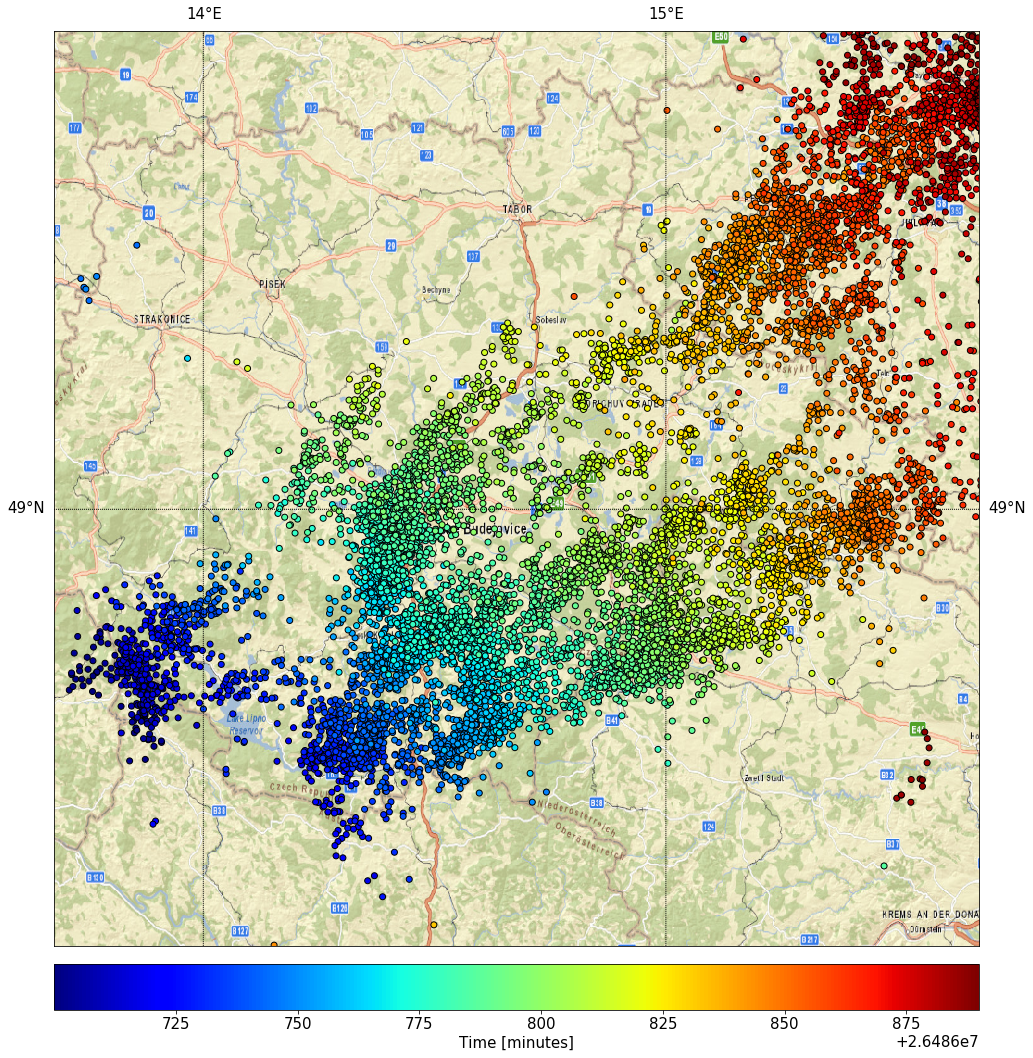

In [82]:
import time, calendar, datetime, numpy
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
import urllib, os
import matplotlib

matplotlib.rcParams.update({'font.size': 15})

plt.figure(figsize=(18,18))
plt.tight_layout()
df6 = blitz
#df6.dropna(inplace=True)
df6['lat'] = pd.to_numeric(df6['lat'])
df6['lon'] = pd.to_numeric(df6['lon'])
#df6['altitude'] = pd.to_numeric(df6['altitude'])
print(float(df6['lat'].tail(1)), " ", float(df6['lon'].tail(1)))

#m = Basemap(llcrnrlon=df6['lon'][-1:]-0.2,llcrnrlat=df6['lat'][-1:]-0.1,urcrnrlon=df6['lon'][-1:]+0.2, urcrnrlat=df6['lat'][-1:]+0.1,  epsg = 3395,resolution='i',projection='merc')
#m = Basemap(llcrnrlon=df6['lon'][-1:]-2.0,llcrnrlat=df6['lat'][-1:]-1.0,urcrnrlon=df6['lon'][-1:]+0.5, urcrnrlat=df6['lat'][-1:]+1.0,  epsg = 3395,resolution='i',projection='merc')
m = Basemap(llcrnrlon=lon-1.0,llcrnrlat=lat-0.8,urcrnrlon=lon+1.0, urcrnrlat=lat+0.5,  epsg = 3395,resolution='i',projection='merc')
m.arcgisimage(service='ESRI_StreetMap_World_2D', xpixels = 1000, verbose= True)
x, y = m(df6.lon.tolist(),df6.lat.tolist())
m.drawparallels(np.arange(0.,99.,1.0),labels=[1,1,0,0])
m.drawmeridians(np.arange(0.,20.,1.0),labels=[0,0,1,0])        
#im1 = m.scatter(x,y,marker='P', s = 500)


im1 = m.scatter(x,y,c=(df6.time/1000000000/60).tolist(),marker='o', edgecolors='black', cmap='jet')
cb = m.colorbar(im1,"bottom", size="5%", pad="2%")
cb.set_label('Time [minutes]')

plt.show() 


47.880541   14.118343
http://server.arcgisonline.com/ArcGIS/rest/services/ESRI_StreetMap_World_2D/MapServer/export?bbox=1544819.906625004,6187827.826649863,1611611.6011009684,6238406.253379119&bboxSR=3395&imageSR=3395&size=1000,757&dpi=96&format=png32&transparent=true&f=image


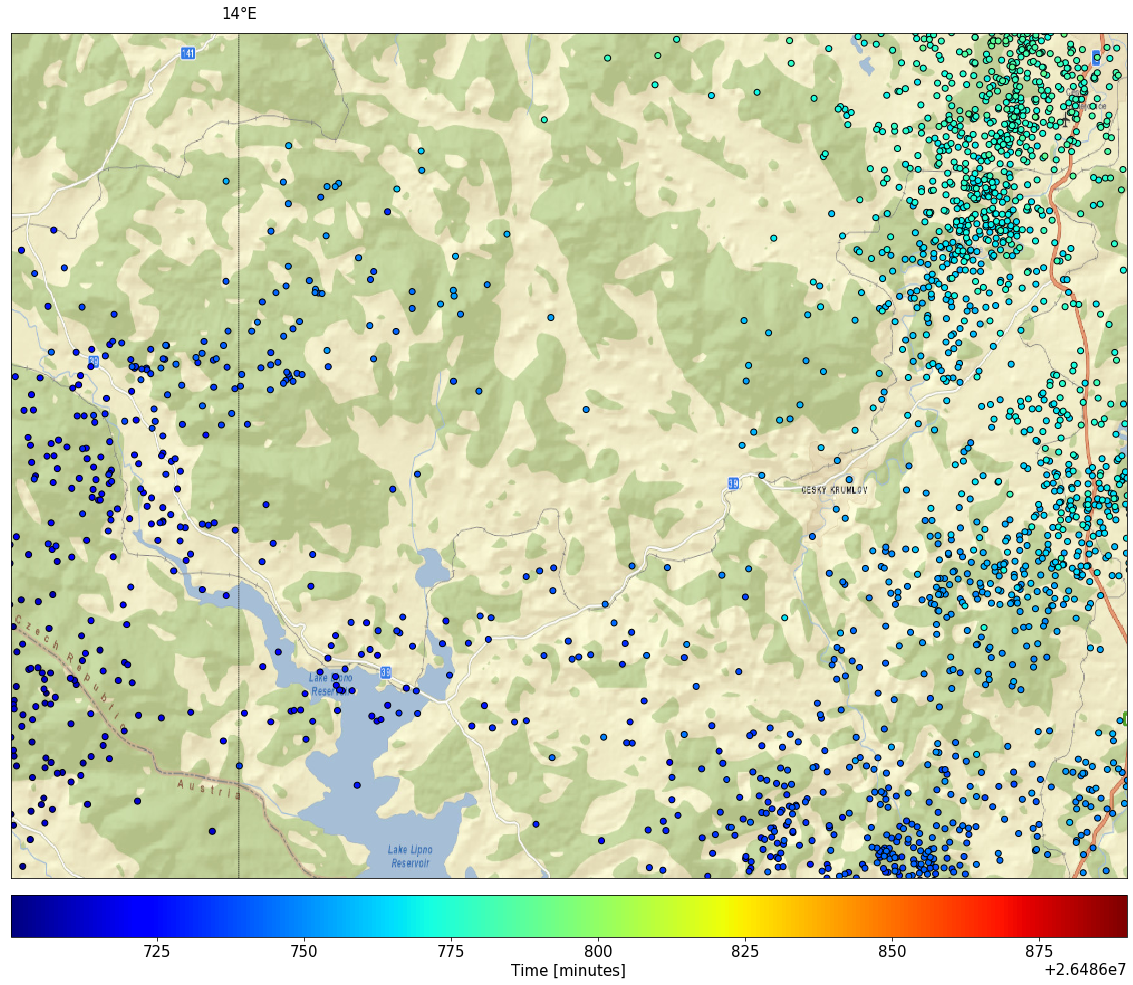

In [81]:
import time, calendar, datetime, numpy
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
import urllib, os
import matplotlib

matplotlib.rcParams.update({'font.size': 15})

plt.figure(figsize=(20,20))
plt.tight_layout()
df6 = blitz
#df6.dropna(inplace=True)
df6['lat'] = pd.to_numeric(df6['lat'])
df6['lon'] = pd.to_numeric(df6['lon'])
#df6['altitude'] = pd.to_numeric(df6['altitude'])
print(float(df6['lat'].tail(1)), " ", float(df6['lon'].tail(1)))

#m = Basemap(llcrnrlon=df6['lon'][-1:]-0.2,llcrnrlat=df6['lat'][-1:]-0.1,urcrnrlon=df6['lon'][-1:]+0.2, urcrnrlat=df6['lat'][-1:]+0.1,  epsg = 3395,resolution='i',projection='merc')
#m = Basemap(llcrnrlon=df6['lon'][-1:]-2.0,llcrnrlat=df6['lat'][-1:]-1.0,urcrnrlon=df6['lon'][-1:]+0.5, urcrnrlat=df6['lat'][-1:]+1.0,  epsg = 3395,resolution='i',projection='merc')
m = Basemap(llcrnrlon=lon-0.8,llcrnrlat=lat-0.5,urcrnrlon=lon-0.2, urcrnrlat=lat-0.2,  epsg = 3395,resolution='i',projection='merc')
m.arcgisimage(service='ESRI_StreetMap_World_2D', xpixels = 1000, verbose= True)
x, y = m(df6.lon.tolist(),df6.lat.tolist())
m.drawparallels(np.arange(0.,99.,1.0),labels=[1,1,0,0])
m.drawmeridians(np.arange(0.,20.,1.0),labels=[0,0,1,0])        
#im1 = m.scatter(x,y,marker='P', s = 500)


im1 = m.scatter(x,y,c=(df6.time/1000000000/60).tolist(),marker='o', edgecolors='black', cmap='jet')
cb = m.colorbar(im1,"bottom", size="5%", pad="2%")
cb.set_label('Time [minutes]')

plt.show() 
